In [1]:
# /kaggle/input/skin-cancer-mnist-ham10000

#### The following notebook has been created in kaggle for easy and direct use of the dataset

The provided code demonstrates efficient memory optimization techniques throughout its implementation. Firstly, it leverages the TensorFlow tf.data.Dataset API to create a data pipeline that efficiently loads and preprocesses the images in a streaming fashion, minimizing memory consumption. Additionally, the code utilizes the shuffle method to randomly shuffle the training, validation, and test datasets, which helps in reducing bias and improving generalization.

To further optimize memory usage, the code explicitly deletes unnecessary variables using del and calls gc.collect() to trigger garbage collection, freeing up memory space after their usage. This helps prevent memory leaks and ensures efficient memory management during the training process.

The code also implements a custom callback called MemoryClearCallback, which clears the memory at the end of each epoch. By releasing memory resources explicitly, it ensures that memory consumption does not accumulate over time and maintains the overall stability and efficiency of the training process.

Overall, the code demonstrates good programming practices by considering memory optimization strategies, such as efficient data loading, variable deletion, garbage collection, and custom callbacks. These optimizations contribute to a more robust and memory-efficient implementation, allowing for smoother execution and improved performance.

In [ ]:
import numpy as np
import tensorflow as tf
import PIL
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import gc # garbage collector


In [3]:
def plot_Model_lossAcc(his):
    plt.figure(figsize = (16,8))

    plt.subplot(2,2,1)
    plt.plot(his.history['loss'])
    plt.plot(his.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()
    
    plt.figure(figsize = (16,8))

    plt.subplot(2,2,2)
    plt.plot(his.history['accuracy'])
    plt.plot(his.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [4]:
path = '/kaggle/input/skin-cancer-mnist-ham10000/'
p1 = 'HAM10000_images_part_1/'
p2 = 'HAM10000_images_part_2/'
meta = 'HAM10000_metadata.csv'

### bkl: Benign keratosis
### nv: Melanocytic nevi
### df: Dermatofibroma
### mel: Melanoma
### vasc: Vascular skin lesions
### bcc: Basal cell carcinoma
### akiec: Actinic Keratoses and Intraepithelial Carcinoma

In [5]:
cancer_df = pd.read_csv(path+meta)

In [6]:
print(cancer_df['dx'].unique())
classnames = cancer_df['dx'].unique()
separate_dict = {}

for unique_class in classnames:
    temp = cancer_df.loc[cancer_df['dx'] == unique_class,['image_id']]
    separate_dict[unique_class] = temp['image_id'].tolist()
print(separate_dict.keys())
   

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
dict_keys(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'])


In [7]:
name = [(os.listdir(path + x)) for x in os.listdir(path) if os.path.isdir(path + x)]
name.remove(name[3]) # Removes duplicate entries
name.remove(name[1]) # Removes duplicate entries
all_names = name[0]+name[1] # Creates a list of all image names
all_path = [path+p1+x for x in name[0]]+[path+p2+x for x in name[1]] # Creates a list of all image paths


In [8]:
# Generate one hot encodings for all classes
encoder_keys = list(separate_dict.keys())
encoder_template = {}
for i in encoder_keys:
    if i == 'bkl':
        encoder_template[i] = [1,0,0,0,0,0,0]
    elif i == 'nv':
        encoder_template[i] = [0,1,0,0,0,0,0]
    elif i == 'df':
        encoder_template[i] = [0,0,1,0,0,0,0]
    elif i == 'mel':
        encoder_template[i] = [0,0,0,1,0,0,0]
    elif i == 'vasc':
        encoder_template[i] = [0,0,0,0,1,0,0]
    elif i == 'bcc':
        encoder_template[i] = [0,0,0,0,0,1,0]
    elif i == 'akiec':
        encoder_template[i] = [0,0,0,0,0,0,1]

print(encoder_template)

{'bkl': [1, 0, 0, 0, 0, 0, 0], 'nv': [0, 1, 0, 0, 0, 0, 0], 'df': [0, 0, 1, 0, 0, 0, 0], 'mel': [0, 0, 0, 1, 0, 0, 0], 'vasc': [0, 0, 0, 0, 1, 0, 0], 'bcc': [0, 0, 0, 0, 0, 1, 0], 'akiec': [0, 0, 0, 0, 0, 0, 1]}


In [9]:
# Generate one hot encodings
all_encodings = []
for img_name in all_names:
    temp1 = img_name.split('.')
    if temp1[0] in separate_dict['bkl']:
        all_encodings.append(encoder_template['bkl'])
        
    elif temp1[0] in separate_dict['nv']:
        all_encodings.append(encoder_template['nv'])
        
    elif temp1[0] in separate_dict['df']:
        all_encodings.append(encoder_template['df'])
        
    elif temp1[0] in separate_dict['mel']:
        all_encodings.append(encoder_template['mel'])
        
    elif temp1[0] in separate_dict['vasc']:
        all_encodings.append(encoder_template['vasc'])
        
    elif temp1[0] in separate_dict['bcc']:
        all_encodings.append(encoder_template['bcc'])
        
    elif temp1[0] in separate_dict['akiec']:
        all_encodings.append(encoder_template['akiec'])

print(len(all_encodings))    
    

10015


In [10]:
# Assign one hot encodings to all the image paths in sync
all_path_encodings = list(zip(all_path,all_encodings))
random.shuffle(all_path_encodings)
all_path,all_encodings = zip(*all_path_encodings)

print(all_path_encodings[0])

('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0029241.jpg', [0, 0, 0, 1, 0, 0, 0])


In [11]:
data_pipeline = tf.data.Dataset.from_tensor_slices((list(all_path),list(all_encodings)))

In [12]:
del all_path, all_encodings, all_path_encodings, all_names, name, separate_dict, encoder_keys, encoder_template, classnames, cancer_df
gc.collect()

0

In [13]:
def load_images_and_process(image_path,one_hot_vec):
    '''load images and decode jpeg'''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
#     return image,one_hot_vec

# def process_image(image,one_hot_vec):
    '''normalise from 0-255 to 0-1'''
#     image = tf.cast(image, tf.float16) / 255.0
    image = tf.image.resize(image, [90,120])
    image = image/255
    return image,one_hot_vec


In [14]:
data_pipeline = data_pipeline.map(load_images_and_process).prefetch(tf.data.AUTOTUNE)#.map(process_image)


In [15]:

# Train, test, validation split
train_size = int(0.8*len(data_pipeline))
val_size = int(0.1*len(data_pipeline))
test_size =int(len(data_pipeline)) - train_size - val_size
print(len(data_pipeline),train_size,val_size,test_size)

train_ds = data_pipeline.take(train_size)
val_ds = data_pipeline.take(val_size)
test_ds = data_pipeline.take(test_size)


train_ds = train_ds.shuffle(10000)
val_ds = val_ds.shuffle(1000)
test_ds = test_ds.shuffle(1000)

10015 8012 1001 1002


In [16]:
print(len(val_ds),len(train_ds),len(test_ds))
del data_pipeline
gc.collect()

1001 8012 1002


0

In [17]:
# Model building

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(30, (5,5),strides = (1,1), padding = 'valid', activation = 'relu', input_shape = (90,120, 3)))
# model.add(tf.keras.layers.Conv2D(32, (3,3),strides = (1,1), padding = 'valid', activation = 'relu', input_shape = (32,32,2)))
model.add(tf.keras.layers.Conv2D(30,(3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = None, padding = 'valid'))

model.add(tf.keras.layers.Conv2D(20,(3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(15,(3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=8))
# model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(15, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.GroupNormalization(groups=3))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = None, padding = 'valid'))

# model.add(tf.keras.layers.Conv2D(8, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.Conv2D(8, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=8))
# # model.add(tf.keras.layers.Conv2D(6, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=8))

# model.add(tf.keras.layers.Conv2D(6, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=6))

model.add(tf.keras.layers.Conv2D(10, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=6))

# model.add(tf.keras.layers.Conv2D(64, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.Conv2D(64, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))

# model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = None, padding = 'valid'))
# model.add(tf.keras.layers.Conv2D(8,(3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.Conv2D(4,(3,3), strides = (1,1), padding = 'valid', activation = 'relu'))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Normalization())
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(1024,activation = 'relu'))
model.add(tf.keras.layers.Dense(256,activation = 'relu'))

# model.add(tf.keras.layers.LayerNormalization())
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128,activation = 'relu'))
# model.add(tf.keras.layers.Normalization())

# model.add(tf.keras.layers.Dense(64,activation = 'relu'))
# model.add(tf.keras.layers.Normalization())

# model.add(tf.keras.layers.Dense(128,activation = 'relu'))

model.add(tf.keras.layers.Dense(7,activation = 'softmax'))

In [18]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 86, 116, 30)       2280      
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 114, 30)       8130      
                                                                 
 batch_normalization (BatchN  (None, 84, 114, 30)      120       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 57, 30)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 55, 20)        5420      
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 53, 15)        2

In [20]:
epochs = 50
batch_size = 8

checkpoint_filepath = '/kaggle/working/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy')
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='EarlyStopping', patience=5)
def scheduler(epoch, lr):
    flr = 1e-3
    if epoch < epochs*0.1 :
        return flr
    elif epoch > epochs*0.1 and epoch < epochs*0.25:
        lr *= tf.math.exp(-0.1)
        return lr
    else:
        lr *= tf.math.exp(-0.008)
#         return lr * tf.math.exp(-0.004)
        return lr
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Memory clear on every epoch
class MemoryClearCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
memory_clear_callback = MemoryClearCallback()

In [21]:
history = model.fit(train_ds.batch(batch_size),epochs=epochs,validation_data=val_ds.batch(batch_size),callbacks=[model_checkpoint_callback,EarlyStop,memory_clear_callback],shuffle=True)

Epoch 1/50
1002/1002 [==============================] - 98s 18ms/step - loss: 1.0388 - accuracy: 0.6549 - val_loss: 1.4498 - val_accuracy: 0.6803
Epoch 2/50
1002/1002 [==============================] - 57s 17ms/step - loss: 0.8972 - accuracy: 0.6860 - val_loss: 3.2202 - val_accuracy: 0.6743
Epoch 3/50
1002/1002 [==============================] - 57s 17ms/step - loss: 0.8551 - accuracy: 0.6931 - val_loss: 1.4214 - val_accuracy: 0.6823
Epoch 4/50
1002/1002 [==============================] - 57s 18ms/step - loss: 0.8183 - accuracy: 0.7082 - val_loss: 1.1425 - val_accuracy: 0.6963
Epoch 5/50
1002/1002 [==============================] - 56s 17ms/step - loss: 0.7746 - accuracy: 0.7214 - val_loss: 1.7369 - val_accuracy: 0.6833
Epoch 6/50
1002/1002 [==============================] - 57s 17ms/step - loss: 0.7570 - accuracy: 0.7248 - val_loss: 0.8608 - val_accuracy: 0.7223
Epoch 7/50
1002/1002 [==============================] - 57s 18ms/step - loss: 0.7284 - accuracy: 0.7379 - val_loss: 1.4369 -

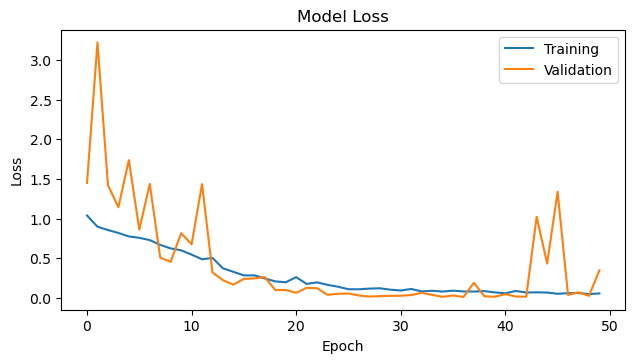

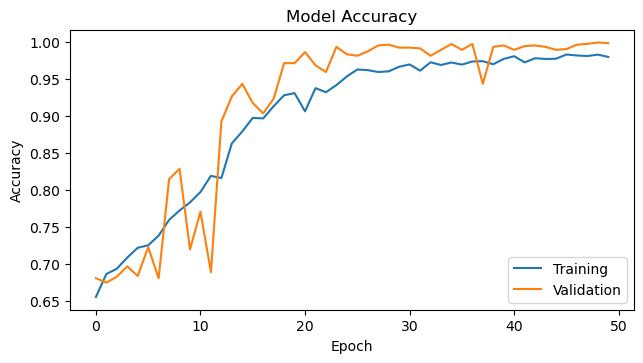

In [22]:
plot_Model_lossAcc(history)


In [42]:
# model.save('/kaggle/working/model777',include_optimizer=True)
import shutil
shutil.make_archive('recentbest777', 'zip', '/kaggle/working')

'/kaggle/working/recentbest777.zip'